In [2]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot
import pickle

In [3]:
# reading transaction dataset
data= pd.read_csv('data/transactions.csv')

In [4]:
# exploratory data anlysis of transaction data file
# total unique transactions, users, start and end date
data.ID.nunique(), data.USER_ID.nunique(), data.shape, data.CREATED_DATE.max(), data.CREATED_DATE.min(),data.STATE.nunique(),data.TYPE.nunique()

(1068361,
 200250,
 (1068361, 7),
 '2019-05-18 00:50:58.493',
 '2019-04-03 00:09:37.571',
 4,
 6)

In [5]:
# having a look and data and identify missing values
print(data.describe())
print(data.head())

         AMOUNT_GBP
count  1.068361e+06
mean   3.408766e+01
std    2.350485e+02
min    1.000000e-02
25%    1.000000e-02
50%    8.370000e+00
75%    1.702000e+01
max    8.325073e+04
                                     ID                               USER_ID  \
0  f659b44e-cfdf-48de-bcf3-06f47ef26e9f  fd7f3ff6-0ed6-4a85-a7b5-2f205e0ef72f   
1  2ae18b8b-b9bc-4c44-96b1-d43efd8d371d  3979518e-95f7-4b6c-81ae-2f828727d81a   
2  0162d352-dd18-40ab-b3ee-cf6584c9a238  75aa5388-9c89-4f72-bc54-67501519585b   
3  a4e176f7-49ca-462b-9164-2f0645622148  45598164-6362-4ee4-bd70-ffee3bd1d707   
4  f6f9135f-fb2b-4a58-bb65-dd9713306a71  5a501ce5-f03c-410d-aabc-434b2cad741d   

              CREATED_DATE          TYPE      STATE  AMOUNT_GBP CURRENCY  
0   2019-04-20 18:04:03.93  CARD_PAYMENT  COMPLETED       13.12      PLN  
1  2019-05-03 13:09:57.625         TOPUP   REVERTED        0.01      RON  
2  2019-04-25 15:37:46.837         TOPUP  COMPLETED       10.00      GBP  
3  2019-04-28 13:52:15.256      E

In [6]:
# load other data files 
fraudester_data= pd.read_csv('data/fraudsters.csv')
user_data= pd.read_csv('data/users.csv')
user_data.rename(columns= {'ID' : 'USER_ID'}, inplace=True)

In [7]:
# having a look at users and fraudester datasets. 
print(fraudester_data.head(), '\n\n\n\n')
print(user_data.head())

# need to create a new column to merge all users with fraud status
fraudester_data['frauderster']= 1

                                USER_ID
0  2c831c76-2d62-41ce-a240-e12f505d389a
1  ce2a1146-831e-49a7-aa5f-a3045a2892af
2  447abe11-f89a-4819-bea2-e7978b1cf560
3  3a186446-c2fb-474b-a8d8-db362643b3d2
4  73fa6100-f6f0-4e22-b247-714f4743c125 




                                USER_ID             CREATED_DATE COUNTRY  \
0  46f44852-aaa5-4634-aadd-8cc4eefef3c8  2019-04-22 18:30:30.735      BG   
1  f17dd8af-2edb-4415-a950-d90a1b5e3e5b   2019-04-15 02:44:24.94      IE   
2  55e6fcef-f573-4c54-8b27-537adc417e19   2019-04-03 16:10:44.53      PL   
3  dc03019c-9cf1-4081-a70a-6922a44fe393  2019-04-13 14:16:11.928      FR   
4  bcd967e5-c273-45a7-a7f5-e7c9e3b19b7e  2019-04-03 15:46:43.997      IE   

   BIRTH_DATE  
0  1984-10-22  
1  1984-11-04  
2  1977-09-08  
3  1992-09-06  
4  1993-10-22  


In [8]:
# crate a merged dataset
user_fraudester_data= pd.merge(user_data, fraudester_data, on='USER_ID', how= 'left')
print(user_fraudester_data.head())

# checking if all fraudsters are present in user data
print(len(user_fraudester_data[user_fraudester_data['frauderster'] == 1]))
print(len(user_data))
print(len(fraudester_data))

                                USER_ID             CREATED_DATE COUNTRY  \
0  46f44852-aaa5-4634-aadd-8cc4eefef3c8  2019-04-22 18:30:30.735      BG   
1  f17dd8af-2edb-4415-a950-d90a1b5e3e5b   2019-04-15 02:44:24.94      IE   
2  55e6fcef-f573-4c54-8b27-537adc417e19   2019-04-03 16:10:44.53      PL   
3  dc03019c-9cf1-4081-a70a-6922a44fe393  2019-04-13 14:16:11.928      FR   
4  bcd967e5-c273-45a7-a7f5-e7c9e3b19b7e  2019-04-03 15:46:43.997      IE   

   BIRTH_DATE  frauderster  
0  1984-10-22          NaN  
1  1984-11-04          NaN  
2  1977-09-08          NaN  
3  1992-09-06          NaN  
4  1993-10-22          NaN  
757
200250
757


(array([2.0075e+04, 2.2491e+04, 1.9476e+04, 3.7590e+03, 8.8900e+03,
        3.1290e+03, 5.0980e+04, 1.7104e+04, 1.9208e+04, 9.7700e+02,
        6.9560e+03, 1.1700e+03, 2.8890e+03, 1.1440e+03, 2.0760e+03,
        1.1970e+03, 6.3870e+03, 6.1900e+02, 6.9000e+01, 2.1980e+03,
        1.1760e+03, 2.0100e+02, 2.1860e+03, 5.7000e+01, 2.7260e+03,
        3.7200e+02, 5.1100e+02, 4.3400e+02, 5.7700e+02, 2.0200e+02,
        1.3900e+02, 1.1000e+02, 1.9100e+02, 2.1200e+02, 4.4000e+01,
        2.0000e+01, 1.1200e+02, 1.1900e+02, 3.5000e+01, 6.0000e+00,
        2.0000e+00, 6.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00,
        2.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00, 3.0000e+00]),
 array([ 0.  ,  1.12,  2.24,  3.36,  4.48,  5.6 ,  6.72,  7.84,  8.96,
        10.08, 11.2 , 12.32, 13.44, 14.56, 15.68, 16.8 , 17.92, 19.04,
        20.16, 21.28, 22.4 , 23.52, 24.64, 25.76, 26.88, 28.  , 29.12,
        30.24, 31.36, 32.48, 33.6 , 34.72, 35.84, 36.96, 38.08, 39.2 ,
        40.32, 41.44, 42.56, 43.68

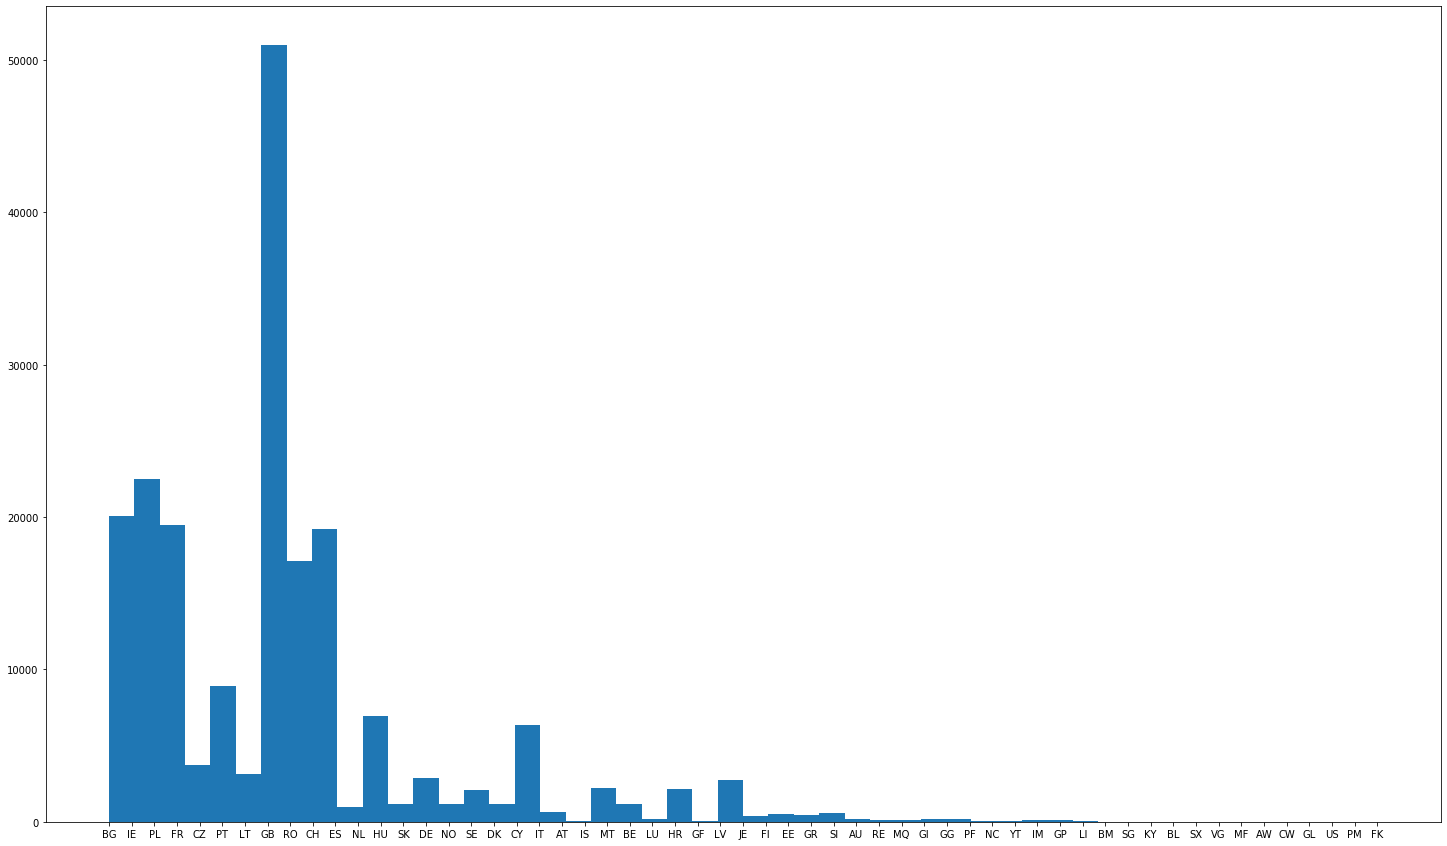

In [9]:
plt.figure(figsize=(25,15))
plt.hist(user_fraudester_data['COUNTRY'], bins = 50)

In [10]:
# create a new feature which is fraud rate of country of transaction

# get total transactions
user_fraudester_data['count']= 1
grouped_fraudester= user_fraudester_data.groupby(['COUNTRY']).agg({'count':np.sum})
country =grouped_fraudester.sort_values( by='count', ascending=False)
print(country.head())

# getting fraud transaction
fraud_country =user_fraudester_data[user_fraudester_data['frauderster']== 1].groupby(['COUNTRY']).agg({'count':np.sum})
f_country =fraud_country.sort_values( by='count', ascending=False)
print(f_country.head())

# getting fraud rate as number of fraud transactions* 100/total transactions
country['con']= country.index
f_country['con']= f_country.index
fraud_rate_data= pd.merge(country, f_country, on ='con')
fraud_rate_data['fraud_rate']= fraud_rate_data['count_y']*100/fraud_rate_data.count_x
Fraud_rate= fraud_rate_data.drop(['count_x', 'count_y'], axis= 1)
Fraud_rate.head(10)

         count
COUNTRY       
GB       50980
PL       22491
FR       19476
IE       17923
RO       17104
         count
COUNTRY       
GB         504
FR         143
IT          36
IE          13
PT          11


,con,fraud_rate
0,GB,0.988623
1,PL,0.022231
2,FR,0.734237
3,IE,0.072533
4,RO,0.035080
5,ES,0.042528
6,PT,0.123735
7,IT,0.913938
8,LT,0.031959
9,DE,0.242298


In [11]:
# creating a dataset that merges all 3 data files
all_transaction_data=pd.merge(data, user_fraudester_data, on= 'USER_ID', how= 'left')
all_transaction_data.head(2)

,ID,USER_ID,CREATED_DATE_x,TYPE,STATE,AMOUNT_GBP,CURRENCY,CREATED_DATE_y,COUNTRY,BIRTH_DATE,frauderster,count
0,f659b44e-cfdf-48de-bcf3-06f47ef26e9f,fd7f3ff6-0ed6-4a85-a7b5-2f205e0ef72f,2019-04-20 18:04:03.93,CARD_PAYMENT,COMPLETED,13.12,PLN,2019-04-18 10:59:26.974,PL,1959-04-08,NaN,1
1,2ae18b8b-b9bc-4c44-96b1-d43efd8d371d,3979518e-95f7-4b6c-81ae-2f828727d81a,2019-05-03 13:09:57.625,TOPUP,REVERTED,0.01,RON,2019-05-03 13:03:46.883,RO,1993-08-12,NaN,1


In [12]:
# data cleaning- changing data types, renaming columns
sum(all_transaction_data['frauderster']== 1)
all_transaction_data.frauderster.fillna(0, inplace=True)
all_transaction_data.CREATED_DATE_x =all_transaction_data.CREATED_DATE_x.astype(np.datetime64)
all_transaction_data.rename(columns={"CREATED_DATE_x": "transaction_date", "CREATED_DATE_y": "user_creation_date"}, inplace=True)
all_transaction_data.user_creation_date =all_transaction_data.user_creation_date.astype(np.datetime64)


### creating features- difference between user creating and fraud date
all_transaction_data['time_diff']= all_transaction_data['transaction_date']- all_transaction_data['user_creation_date']
all_transaction_data['time_diff']= all_transaction_data['time_diff'] / pd.to_timedelta(1, unit='D')
print(all_transaction_data.head())

                                     ID                               USER_ID  \
0  f659b44e-cfdf-48de-bcf3-06f47ef26e9f  fd7f3ff6-0ed6-4a85-a7b5-2f205e0ef72f   
1  2ae18b8b-b9bc-4c44-96b1-d43efd8d371d  3979518e-95f7-4b6c-81ae-2f828727d81a   
2  0162d352-dd18-40ab-b3ee-cf6584c9a238  75aa5388-9c89-4f72-bc54-67501519585b   
3  a4e176f7-49ca-462b-9164-2f0645622148  45598164-6362-4ee4-bd70-ffee3bd1d707   
4  f6f9135f-fb2b-4a58-bb65-dd9713306a71  5a501ce5-f03c-410d-aabc-434b2cad741d   

         transaction_date          TYPE      STATE  AMOUNT_GBP CURRENCY  \
0 2019-04-20 18:04:03.930  CARD_PAYMENT  COMPLETED       13.12      PLN   
1 2019-05-03 13:09:57.625         TOPUP   REVERTED        0.01      RON   
2 2019-04-25 15:37:46.837         TOPUP  COMPLETED       10.00      GBP   
3 2019-04-28 13:52:15.256      EXCHANGE  COMPLETED        0.11      RON   
4 2019-05-13 16:02:12.081  CARD_PAYMENT  COMPLETED        9.79      EUR   

       user_creation_date COUNTRY  BIRTH_DATE  frauderster  co

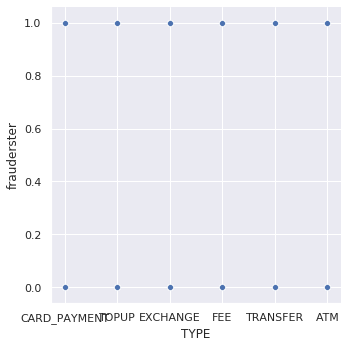

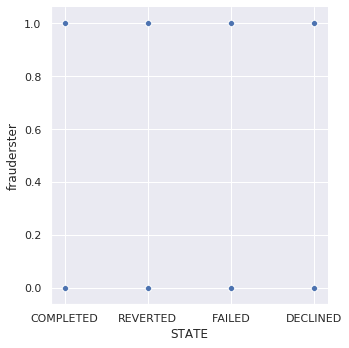

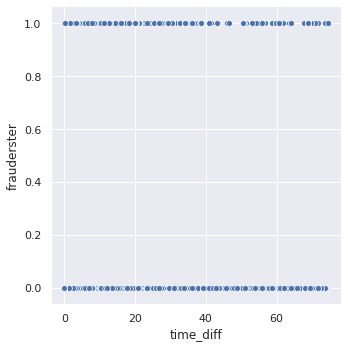

In [13]:
# bi-variate analysis keeping one variable as fraud status
sns.set()
cols= ["TYPE", "STATE", "time_diff"]
for c in cols:
    p= sns.relplot(x=c, y="frauderster", 
            data=all_transaction_data)
    print(p)

In [14]:
# creating new features from the transaction variable

all_transaction_data['day_of_week']= all_transaction_data['transaction_date'].dt.dayofweek
all_transaction_data['time_of_day']= all_transaction_data['transaction_date'].dt.hour
all_transaction_data['BIRTH_DATE']= all_transaction_data['BIRTH_DATE'].astype(np.datetime64)
all_transaction_data['age']= pd.Timestamp(2019, 12, 12, 12) - all_transaction_data['BIRTH_DATE']
all_transaction_data['age'] = all_transaction_data['age'] / pd.to_timedelta(1, unit='D')

all_transaction_data['TransYear']=all_transaction_data['transaction_date'].map(lambda x: x.year )
all_transaction_data['TransMonth']=all_transaction_data['transaction_date'].map(lambda x: x.month )
all_transaction_data['TransDay']=all_transaction_data['transaction_date'].map(lambda x: x.day )
all_transaction_data['TransHour']=all_transaction_data['transaction_date'].map(lambda x: x.hour )


In [15]:
all_transaction_data.head(5)

,ID,USER_ID,transaction_date,TYPE,STATE,AMOUNT_GBP,CURRENCY,user_creation_date,COUNTRY,BIRTH_DATE,frauderster,count,time_diff,day_of_week,time_of_day,age,TransYear,TransMonth,TransDay,TransHour
0,f659b44e-cfdf-48de-bcf3-06f47ef26e9f,fd7f3ff6-0ed6-4a85-a7b5-2f205e0ef72f,2019-04-20 18:04:03.930,CARD_PAYMENT,COMPLETED,13.12,PLN,2019-04-18 10:59:26.974,PL,1959-04-08,0.0,1,2.294872,5,18,22163.5,2019,4,20,18
1,2ae18b8b-b9bc-4c44-96b1-d43efd8d371d,3979518e-95f7-4b6c-81ae-2f828727d81a,2019-05-03 13:09:57.625,TOPUP,REVERTED,0.01,RON,2019-05-03 13:03:46.883,RO,1993-08-12,0.0,1,0.004291,4,13,9618.5,2019,5,3,13
2,0162d352-dd18-40ab-b3ee-cf6584c9a238,75aa5388-9c89-4f72-bc54-67501519585b,2019-04-25 15:37:46.837,TOPUP,COMPLETED,10.00,GBP,2019-04-25 15:31:00.259,GB,1988-04-21,0.0,1,0.004706,3,15,11557.5,2019,4,25,15
3,a4e176f7-49ca-462b-9164-2f0645622148,45598164-6362-4ee4-bd70-ffee3bd1d707,2019-04-28 13:52:15.256,EXCHANGE,COMPLETED,0.11,RON,2019-04-28 13:39:18.900,GB,1997-01-13,0.0,1,0.008986,6,13,8368.5,2019,4,28,13
4,f6f9135f-fb2b-4a58-bb65-dd9713306a71,5a501ce5-f03c-410d-aabc-434b2cad741d,2019-05-13 16:02:12.081,CARD_PAYMENT,COMPLETED,9.79,EUR,2019-05-03 10:38:55.607,GB,1999-07-22,0.0,1,10.224496,0,16,7448.5,2019,5,13,16


In [ ]:
## selcting columns required for modeling
model_data= all_transaction_data[['TYPE', 'STATE','AMOUNT_GBP','CURRENCY','COUNTRY', 'frauderster', 'time_diff','day_of_week',
                                'age', 'time_of_day','TransYear','TransMonth','TransDay','TransHour']]
# creating a new variable fraud rate
Fraud_rate= Fraud_rate.rename(columns= {'con':'COUNTRY'})
model_data= pd.merge(model_data, Fraud_rate,on= 'COUNTRY', how= 'left')
#model_data.head()

# Categorical boolean mask
categorical_feature_mask = model_data.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = model_data.columns[categorical_feature_mask].tolist()
categorical_cols=['CURRENCY', 'COUNTRY']

# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()
# apply le on categorical feature columns
model_data[categorical_cols] = model_data[categorical_cols].apply(lambda col: le.fit_transform(col))
model_data[categorical_cols].head(10)

model_data= pd.get_dummies(model_data, prefix_sep='_', drop_first=True)
model_data['frauderster']=model_data['frauderster'].astype(int)
# X head
model_data.head()

train, test = train_test_split(model_data, test_size=0.2, random_state=0, stratify=model_data[['frauderster']])
train.groupby('frauderster')["frauderster"].count()


yy= train['frauderster']
xx= train[['AMOUNT_GBP', 'CURRENCY', 'COUNTRY', 'time_diff',
       'day_of_week', 'age', 'time_of_day', 'TransYear', 'TransMonth',
       'TransDay', 'TransHour', 'TYPE_CARD_PAYMENT',
       'TYPE_EXCHANGE', 'TYPE_FEE', 'TYPE_TOPUP', 'TYPE_TRANSFER',
       'STATE_DECLINED', 'STATE_FAILED', 'STATE_REVERTED']]

from imblearn.over_sampling import SMOTENC
sm = SMOTENC(categorical_features=[1,2,4,7,8,9,10,11,12,13,14,15,16,17,18],sampling_strategy=0.05,random_state=42)
X_res, y_res = sm.fit_resample(xx, yy)

X_res_smote=X_res 
y_res_smote=y_res

from imblearn.under_sampling import TomekLinks
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_res_smote, y_res_smote)

xx=X_res
yy=y_res

# checking data types of training data and splitting for test and train dataset
print(xx.dtypes)
xx_df= xx # keeping colimn names
xx=np.array(xx)
yy= np.array(yy).astype(np.int64)
X_train, X_test, y_train, y_test= train_test_split(xx, yy, test_size=.1,shuffle=True, random_state= 42)



In [34]:
len(XX),len(YY)

(889575, 889575)

In [20]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [21]:
len(xx),len(yy)

(889575, 889575)

In [25]:
from sklearn.ensemble import RandomForestClassifier
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='roc_auc', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)
train_features=xx
train_labels=yy
# Fit the random search model
rf_random.fit(train_features, train_labels);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 32.3min


KeyboardInterrupt: 

In [ ]:
rf_random.best_params_

In [ ]:
RandomForestModel = RandomForestClassifier(n_estimators = ,max_features = '',
                                           max_depth =  ,
                                           min_samples_split = ,
                                           min_samples_leaf = ,
                                           bootstrap = True,
                                           random_state=42)
RandomForestModel.fit(xx, yy)

